#Модели на природни јазици

Во оваа вежба се прикажани неколку модели на природни јазици.

За работа со истите ќе користиме повеќе податочни множества, најголем дел од кои се директно земени од [Kaggle](https://www.kaggle.com/).

За да може да ја извршувате оваа вежба, потребно е да:

1.   Имате account на Kaggle, или пак да се најавите на друг начин.
2.   Во вашиот профил, да изберете Account, па Create New API Token (како на сликата во прилог).

 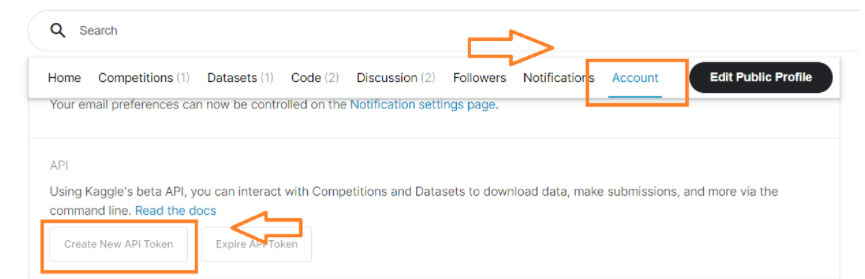

3.   kaggle.json фајлот кој ќе го добиете ставете го во рамки на овој Colab Notebook, така што ќе направите upload (со клик на означеното копче на сликата во прилог).

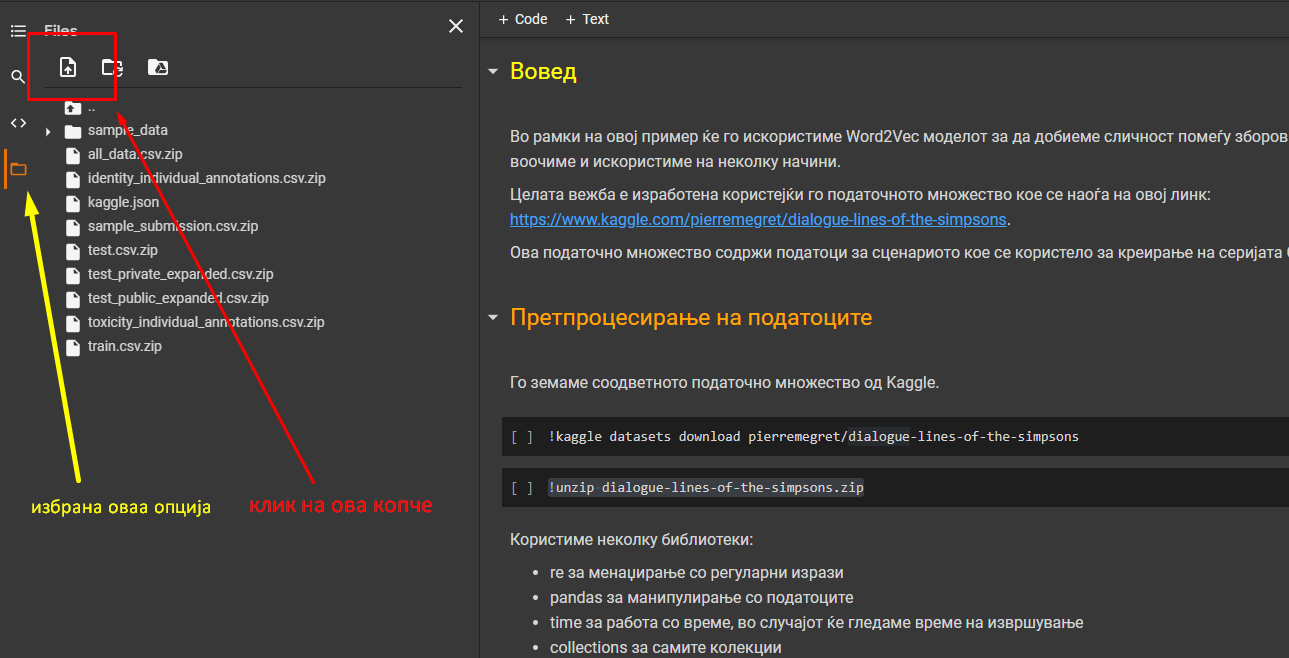


Со тоа сте спремни да ја започнете вежбата, најпрво извршувајќи ги следните две команди кои соодветно ќе го позиционираат фајлот кој го добивте.



In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
! chmod 600 /root/.kaggle/kaggle.json

# Word2Vec


## <font color='yellow'> Вовед </font>



Во рамки на овој пример ќе го искористиме Word2Vec моделот за да добиеме сличност помеѓу зборови, а таквата сличност ќе ја воочиме и искористиме на неколку начини.

Целата вежба е изработена користејќи го податочното множество кое се наоѓа на овој линк: https://www.kaggle.com/pierremegret/dialogue-lines-of-the-simpsons.

Ова податочно множество содржи податоци за сценариото кое се користело за креирање на серијата Симпсонови (The Simpsons).

## <font color='orange'> Претпроцесирање на податоците </font>



Го земаме соодветното податочно множество од Kaggle.

In [3]:
!kaggle datasets download pierremegret/dialogue-lines-of-the-simpsons

dialogue-lines-of-the-simpsons.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip dialogue-lines-of-the-simpsons.zip

Archive:  dialogue-lines-of-the-simpsons.zip
replace simpsons_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


Користиме неколку библиотеки:
- re за менаџирање со регуларни изрази
- pandas за манипулирање со податоците
- time за работа со време, во случајот ќе гледаме време на извршување
- collections за самите колекции
- spacy за претпроцесирање
- gensim.models.phrases за откривање на најчестите фрази (bigrams)
- logging за да овозможиме приказ на логови

In [5]:
import re
import pandas as pd
from time import time
from collections import defaultdict
import spacy
from gensim.models.phrases import Phrases, Phraser
import logging

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

Ги вчитуваме податоците кои се наоѓаат во соодветниот csv фајл.

Податоците се во формат: (name, words_said_during_episodes), односно за секој еден лик во серијата ги имаме сите зборови кои тој лик ги кажал во одредени епизоди.


In [6]:
df = pd.read_csv('simpsons_dataset.csv')
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


Во оваа вежба ќе работиме само со дел од податоците, заради временската ограниченост. 

Пробајте ја вежбата и со целосното податочно множество! 

Дали има разлика во резултатите на крај?

In [7]:
df = df[:30000]

Најпрво, извршуваме лематизација. 
Овој процес ги сведува зборовите до нивниот корен.

Тука, дополнително ги отстрануваме и стоп зборовите (stop words) и карактерите (characters) кои не се букви.

Бидејќи Word2Vec го користи контекстот за да ја добие векторската репрезентација на одреден таргет збор (target word), речениците со 1 или 2 зборови не ни се од голема полза, па нема да ги користиме.

На крај го печатиме времето на извршување на лематизацијата и чистењето на податоците. (во овој случај околу 12 минути)

In [8]:
nlp = spacy.load('en', disable=['ner', 'parser'])
t = time()

def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up data: {} minutes.'.format(round((time() - t) / 60, 2)))

Time to clean up data: 0.26 minutes.


Во понатамошното работење ги користиме исчистените податоци, на кои ги отстрануваме дупликатите и NAN вредностите.

In [9]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()

INFO - 17:06:59: NumExpr defaulting to 2 threads.


Ја креираме листата која ја даваме како input на Phrases. 
Phrases ги креира релевантните фрази од листата на реченици.

In [10]:
sent = [row.split() for row in df_clean['clean']]

phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 17:06:59: collecting all words and their counts
INFO - 17:06:59: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 17:06:59: PROGRESS: at sentence #10000, processed 63561 words and 52816 word types
INFO - 17:06:59: collected 81344 word types from a corpus of 103856 words (unigram + bigrams) and 16003 sentences
INFO - 17:06:59: using 81344 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


Како проверка за овој дел (лематизација, отстранување на stop words и додавање на bigrams), можеме да погледнеме кои зборови се најчести. 

Можеме да забележиме дека до овој момент процесот е успешен, бидејќи најчестите зборови се очекувани како резултат.


In [11]:
word_freq = defaultdict(int)
for s in sent:
    for i in s:
        word_freq[i] += 1

sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'go', 'know', 'get', 'homer', 'hey', 'bart', 'think', 'right']

## <font color='green'> Тренирање и користење на моделот </font>



За тренирање на моделот ја користиме оваа имплементација: https://radimrehurekcom/gensim/models/word2vec.html.

Дополнително ни се потребни следните imports, за да можеме да користиме паралелно процесирање, како и да го користиме самиот модел (имплементацијата на Gensim, дадена на линкот погоре).

In [12]:
import multiprocessing
from gensim.models import Word2Vec

In [13]:
cores = multiprocessing.cpu_count()

Што означуваат овие вредности:
- ***min_count*** - за да се игнорираат сите зборови кои имаат апсолутна фреквенција помала од овој број, може да биде вредност од 2 до 100
- ***window*** - најголемото растојание помеѓу моменталниот и предвидениот збор во дадена реченица, може да биде вредност од 2 до 10
- ***size*** - димензионалноста на векторите (feature vector dimensionality)
- ***sample*** - граница за конфигурирање кои зборови со голема фреквенција ќе бидат downsampled, може да биде вредност од 0 до 1е-5
- ***alpha*** - рата на учење, може да биде вредност од 0.01 до 0.05
- ***min_alpha*** - ратата на учење опаѓа линеарно како што изминува тренирањето, оваа вредност е минималната до која сакаме да стигнеме
- ***negative*** -  доколку сакаме да користиме negative sampling, специфицираме колку noise words ќе земеме
- ***workers*** - бројот на worker threads

In [14]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

Градење на вокабуларот.

In [ ]:
t = time()
w2v_model.build_vocab(sent, progress_per=10000)
print('Time to build vocabulary: {} minutes'.format(round((time() - t) / 60, 2)))

Тренирање на моделот.

In [ ]:
t = time()
w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} minutes'.format(round((time() - t) / 60, 2)))

w2v_model.init_sims(replace=True)

Најпрво, можеме да го искористиме моделот за да видиме кои зборови се најслични помеѓу себе.


In [17]:
w2v_model.wv.most_similar(positive=["homer"])

[('simpson', 0.9998182058334351),
 ('want', 0.9997860193252563),
 ('uh', 0.9997843503952026),
 ('marge', 0.9997662305831909),
 ('time', 0.9997655749320984),
 ('thing', 0.9997588992118835),
 ('hard', 0.9997588396072388),
 ('hey', 0.999758243560791),
 ('good', 0.9997580051422119),
 ('dad', 0.9997563362121582)]

Понатаму, можеме да видиме колкава е сличноста помеѓу два конкретни зборови.

In [18]:
w2v_model.wv.similarity('bart', 'simpson')

0.9997442

Можеме и да погледнеме кој збор не припаѓа на одредена група, односно е најмалку сличен со останатите.

In [19]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'homer'

## <font color='red'> Визуелизација </font>



За да направиме добри визуелизации, ќе искористиме t-SNE. Ова е алгоритам за нелинеарно намалување на димензионалноста, како би можеле да добиеме претстава која ни е видлива и јасна на нас луѓето.

Погледнете го овој линк за повеќе детали:
https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b


Соодветно, додаваме одредени библиотеки:
- numpy - ни дава поддршка за големи и мултимензионални низи и матрици, како и голем број на математички операции врз истите
- matplotlib - за исцртување
- seaborn - за исцртување
- sklearn - за да користиме PCA и TSNE

In [20]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Дефинираме функција која ги исцртува резултатите од t-SNE на векторите за даден збор, неговата листа на најслични зборови и општа листа од зборови.

In [21]:
def tsnescatterplot(model, word, list_names):
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    close_words = model.wv.most_similar([word])
    
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=10).fit_transform(reduc)
    
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 10,'facecolors': df['color']}
                  )
    
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(10)

    
    plt.xlim(Y[:, 0].min()-10, Y[:, 0].max()+10)
    plt.ylim(Y[:, 1].min()-10, Y[:, 1].max()+10)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

Можеме да воочиме дека зборот 'Homer' е многу блиску до 'Husband', 'Report'..., но е многу подалеку на пример од зборот 'Woman'.

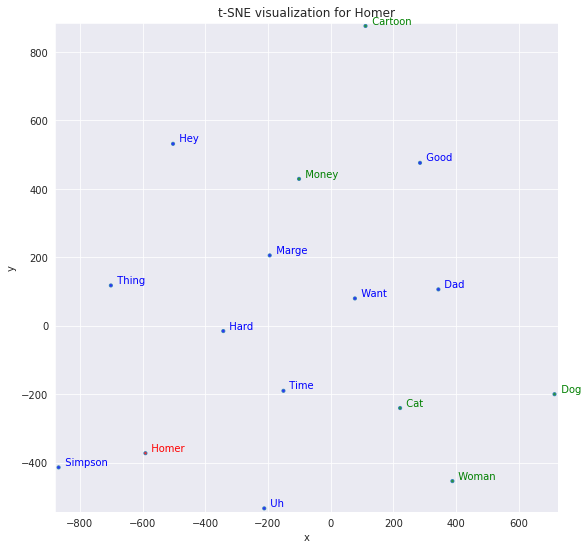

In [22]:
tsnescatterplot(w2v_model, 'homer', ['money', 'woman', 'dog', 'cat', 'cartoon'])

# GloVe


## <font color='yellow'> Вовед </font>



Во рамки на овој пример ќе го искористиме GloVe моделот.


## <font color='orange'> Претпроцесирање на податоците </font>



Најпрво, од Kaggle го земаме податочното множество во прилог. Ова податочно множество содржи податоци во следниот формат:


> word N1 N2 N3 ..... Nn

каде за секој збор има n броеви кои го дефинираат векторот кој ја дава претставата на самиот збор.

In [23]:
!kaggle datasets download watts2/glove6b50dtxt

glove6b50dtxt.zip: Skipping, found more recently modified local copy (use --force to force download)


In [24]:
!unzip glove6b50dtxt.zip

Archive:  glove6b50dtxt.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


Користиме неколку библиотеки, кои ги имавме и во претходните примери. 

TSNE е метод кој овозможува визуелизација на повеќе-димензионални податоци, слично како претходно.

In [25]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

Од фајлот кој ги содржи ваквите вектори за зборовите, креираме dictionary во кое сега за клуч - збор, како вредност ја имаме неговата векторска репрезентација (во форма на numpy низа од вредности).

In [26]:
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

## <font color='green'> Тренирање и користење на моделот </font>





Функцијата find_closest_embeddings прима како параметар embedding кој всушност за нас ќе претставува одреден збор. 

Потоа, за dictionary кое го имаме, а во кое се сите зборови и нивните репрезентации, правиме сортирање. Сортирањето се врши според растојанието помеѓу зборот embedding и конкретниот збор до кој сме стигнале во итерацијата.

In [27]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

Сега, кога ќе ја повикаме оваа функција, даваме ограничување дека сакаме да ги отпечатиме првите 5 зборови, па така ги добиваме 5-те најблиски збора до оној кој ни е од интерес.

In [28]:
print(find_closest_embeddings(embeddings_dict["king"])[:5])

['king', 'prince', 'queen', 'uncle', 'ii']


Бидејќи секогаш најблиску ќе биде самиот тој збор, може да направиме offset за 1.

In [29]:
print(find_closest_embeddings(embeddings_dict["king"])[1:6])

['prince', 'queen', 'uncle', 'ii', 'grandson']


Дополнително, може да направиме и одредена математика врз зборовите. На пример доколку ги собереме векторите на овие два зборови "woman" и "baby", ги добиваме следните резултати за првите 5 најблиски зборови.

In [30]:
print(find_closest_embeddings(
    embeddings_dict["woman"] + embeddings_dict["baby"]
)[1:6])

['girl', 'baby', 'mother', 'boy', 'her']


## <font color='red'> Визуелизација </font>







Дополнително, може да искористиме и визуелизација на податоците.

За ова, ќе искористиме TSNE метод, кој слично како PCA ќе ја намали димензионалноста на податоците, во нашиот случај од 50 димензии на 2.

За подобра прегледност на самите податоци, додаваме и анотација со annotate методот.

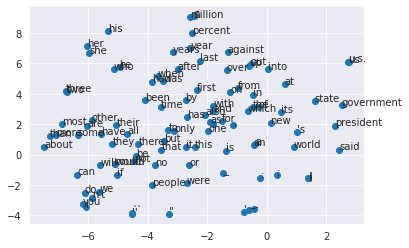

In [31]:
tsne = TSNE(n_components=2, random_state=0)
words =  list(embeddings_dict.keys())
vectors = [embeddings_dict[word] for word in words]
Y = tsne.fit_transform(vectors[:100])

plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

# FastText


## <font color='yellow'> Вовед </font>



Во рамки на овој пример ќе го искористиме FastText моделот за да добиеме сличност помеѓу зборови и истата ќе ја употребиме на неколку начини.

Ќе користиме податоци добиени од Wikipedia.


## <font color='orange'> Претпроцесирање на податоците </font>



Ги инсталираме потребните библиотеки.

In [32]:
!pip install wikipedia

Користиме неколку библиотеки:


*   keras.preprocessing.text за токенизирање
*   gensim.models.fasttext за користење на самата библиотека FastText
*   numpy за поддршка на големи и мултидимензионални низи и матрици
*   matplotlib за приказ
*   nltk за NLP за Англиски јазик

In [33]:
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models.fasttext import FastText
import numpy as np
import matplotlib.pyplot as plt
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer

import wikipedia
import nltk

nltk.download('punkt') #sentence tokenizer
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


За да добиеме податоци од Wikipedia, користиме page метод кој се наоѓа во рамки на wikipedia модулот. Како влезен параметар го даваме името на страната за која сакаме да ги повлечеме податоците. Резултатот од ваквиот метод е од тип WikipediaPage, а за да ги добиеме податоците го пристапуваме content атрибутот на резултатот.

Податоците кои ги добивме се токенизираат користејќи го sent_tokenize методот. Овој метод враќа како резултат листа од реченици. 

На крај ги спојуваме сите реченици, од трите страни, во една листа.

In [34]:
artificial_intelligence = wikipedia.page("Artificial Intelligence").content
deep_learning = wikipedia.page("Deep Learning").content
neural_network = wikipedia.page("Neural Network").content

artificial_intelligence = sent_tokenize(artificial_intelligence)
deep_learning = sent_tokenize(deep_learning)
neural_network = sent_tokenize(neural_network)

artificial_intelligence.extend(deep_learning)
artificial_intelligence.extend(neural_network)

Следен чекор е чистењето и лематизацијата на податоците.

In [35]:
import re
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # Remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substitude multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Remove prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Convert to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

Ја тестираме функцијата за чистење и лематизација на податоците, со еден пример.

In [36]:
sent = preprocess_text("Artificial intelligence, is the most advanced technology of the present era")
print(sent)

artificial intelligence advanced technology present


Откако се уверивме дека е во ред, истата функција ја применуваме на целиот корпус, односно на сите реченици.

In [37]:
final_corpus = [preprocess_text(sentence) for sentence in artificial_intelligence if sentence.strip() !='']

word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in final_corpus]

## <font color='green'> Тренирање и користење на моделот </font>





Следен чекор е креирањето на репрезентациите со помош на FastText.

Најпрво, ги дефинираме параметрите за моделот, односно embedding_size, window_size, min_word и down_sampling. 

*   embedding size се однесува на големината на векторот, односно во нашиот случај секој збор ќе биде претставен како вектор со 60 димензии
*   window size е бројот на зборови пред и по зборот, за кои сакаме да се разгледани при креирањето на репрезентацијата
*   min word се однесува на минималната фреквенција на даден збор во рамки на корпусот, за кој збор ќе се креира репрезентација
*   down sampling дефинира број според кој ќе се врши down sampling на најфреквентните зборови.

Потоа, го креираме моделот.


In [ ]:
embedding_size = 60
window_size = 40
min_word = 5
down_sampling = 1e-2

ft_model = FastText(word_tokenized_corpus,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      iter=100)

Најпрво, да погледнеме како изгледа репрезентацијата на одреден збор.

In [39]:
print(ft_model.wv['artificial'])

[ 0.4860969  -0.10017093  0.09545259 -0.19008897  0.45359704  0.35653475
  0.01305635 -0.8159762   0.08340577  0.14112261 -0.15421568 -0.4264466
 -0.42393938 -0.10382595  0.12698302  0.07256519  0.19672127  0.05891209
  0.4106385  -0.37461042 -0.0843825  -0.03795316 -0.44435     0.07887099
  0.06932943 -0.05912213  0.2299952  -0.09522311  0.2584481   0.5065526
 -0.43725982 -0.05782647 -0.82911235  0.2841319  -0.12067343  0.09410232
  0.00693271  0.40249473  0.53690845 -0.32107878 -0.08860723  0.22264105
  0.28607398 -0.04060451 -0.31275705 -0.12468687  0.2804378  -0.17198211
 -0.36605754  0.4258393  -0.31495294  0.07819248  0.39731655 -0.37547615
 -0.42289495 -0.31450087  0.56306005  0.46096915 -0.36173674  0.19588375]


Следно, може да погледнеме сличност на зборови. 

Во конкретниот пример, за секој од зборовите artificial, intelligence, machine, network, learning ги бараме топ 5-те најслични зборови.

In [40]:
semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=5)]
                  for words in ['artificial', 'intelligence', 'machine', 'network', 'learning']}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

INFO - 17:08:33: precomputing L2-norms of word weight vectors
INFO - 17:08:33: precomputing L2-norms of ngram weight vectors


artificial:['intelligence', 'superintelligence', 'threat', 'paradigm', 'reference']
intelligence:['artificial', 'superintelligence', 'intelligent', 'future', 'risk']
machine:['pattern', 'capable', 'considered', 'ethic', 'observation']
network:['neural', 'recurrent', 'biological', 'convolutional', 'feedforward']
learning:['deep', 'convolutional', 'schmidhuber', 'feature', 'specifically']


Дополнително, може да пресметаме косинусна сличност, како во следниот пример.


In [41]:
print(ft_model.wv.similarity(w1='artificial', w2='superintelligence'))

0.52954453


## <font color='red'> Визуелизација </font>







За да можеме да визуелизираме, повторно, и во овој пример користиме PCA, за да визуелизацијата ни се прикажува во дво-димензионален простор.

In [42]:
from sklearn.decomposition import PCA

all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])

print(all_similar_words)

['artificial', 'intelligence', 'superintelligence', 'threat', 'paradigm', 'reference', 'intelligence', 'artificial', 'superintelligence', 'intelligent', 'future', 'risk', 'machine', 'pattern', 'capable', 'considered', 'ethic', 'observation', 'network', 'neural', 'recurrent', 'biological', 'convolutional', 'feedforward', 'learning', 'deep', 'convolutional', 'schmidhuber', 'feature', 'specifically']


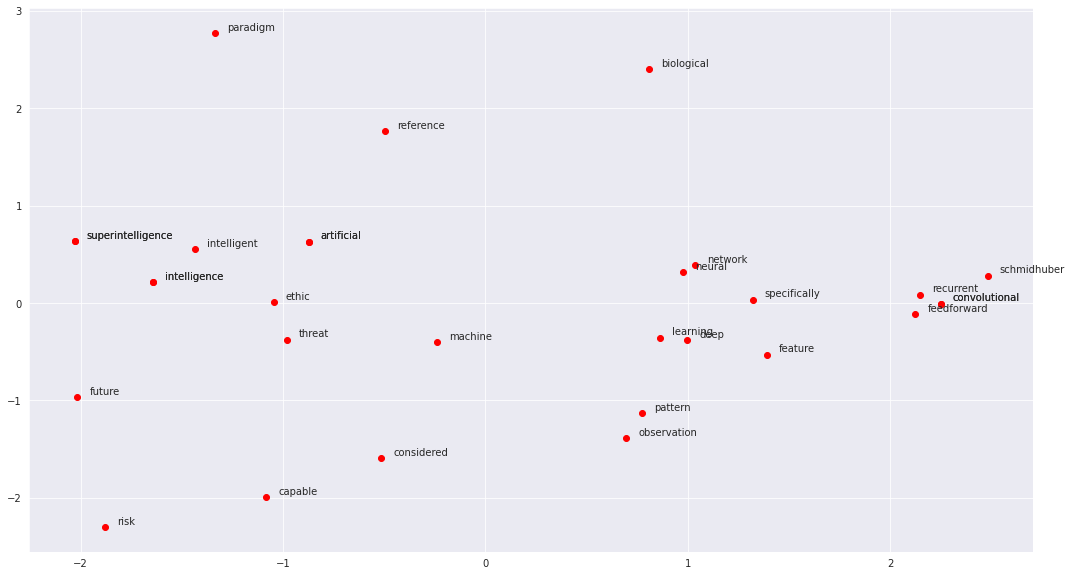

In [43]:
word_vectors = ft_model.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(18, 10))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

# ELMo


## <font color='yellow'> Вовед </font>



Во овој дел ќе го користиме моделот ELMo. За разлика од претходните примери, во овој пример ќе покажеме класификација на текст.

За таа цел ќе го користиме податочното множество кое содржи tweets за кои е даден и сентиментот. Сентиментот во овој случај ќе ни биде target.

In [44]:
!kaggle datasets download datatattle/covid-19-nlp-text-classification

covid-19-nlp-text-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [45]:
!unzip covid-19-nlp-text-classification.zip

Archive:  covid-19-nlp-text-classification.zip
replace Corona_NLP_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Corona_NLP_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


Ги користиме следните библиотеки. Истите веќе ги објаснивме во претходните неколку примери.

In [46]:
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
import re
import time
import pickle
pd.set_option('display.max_colwidth', 200)

Податоците се поделени на два дела: train и test множество. Целта е да го тренираме моделот на првото, а да го тестираме на второто множество.

Задачата ќе биде класификација на нови tweets, според нивниот сентимент.

In [47]:
train = pd.read_csv('Corona_NLP_test.csv')
test = pd.read_csv('Corona_NLP_test.csv')

Да погледнеме како изгледаат податоците.

In [48]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr...",Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and loved ones from #coronavirus. ?,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News #Corvid19 #7NewsMelb #dunnypapergate #Costco One week everyone buying baby milk powder the next ...,Neutral


In [49]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr...",Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and loved ones from #coronavirus. ?,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News #Corvid19 #7NewsMelb #dunnypapergate #Costco One week everyone buying baby milk powder the next ...,Neutral


## <font color='orange'> Претпроцесирање на податоците </font>



Може да погледнеме дека во рамки на податоците, сентиментот е изразен како стринг, и прима една од пет вредности.

Овој дел го поедноставуваме, и соодветно ставаме вредност 0 секаде каде имаме позитивен, екстремно позитивен или неутрален сентимент. Во останатите случаи аменуваме со вредност 1.
Така, класификацијата која ќе ја извршиме ќе биде бинарна.

Во прилог може да се види промената.

In [50]:
train["Sentiment"].replace({"Extremely Positive": 0, "Positive": 0, "Neutral": 0, "Negative": 1, "Extremely Negative": 1}, inplace=True)
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr...",1
1,2,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",0
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and loved ones from #coronavirus. ?,0
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,1
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News #Corvid19 #7NewsMelb #dunnypapergate #Costco One week everyone buying baby milk powder the next ...,0


In [51]:
test["Sentiment"].replace({"Extremely Positive": 0, "Positive": 0, "Neutral": 0, "Negative": 1, "Extremely Negative": 1}, inplace=True)
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr...",1
1,2,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",0
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and loved ones from #coronavirus. ?,0
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,1
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News #Corvid19 #7NewsMelb #dunnypapergate #Costco One week everyone buying baby milk powder the next ...,0


Следен чекор е чистење на податоците.

Најпрво ги отстрануваме url деловите во рамки на самите tweets.

In [52]:
train['clean_tweet'] = train['OriginalTweet'].apply(lambda x: re.sub(r'http\S+', '', x))
test['clean_tweet'] = test['OriginalTweet'].apply(lambda x: re.sub(r'http\S+', '', x))

Потоа, отстрануваме интерпукциски знаци, броеви, празни места, и целосниот текст го правиме да биде целосно во мали букви.

In [53]:
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'

train['clean_tweet'] = train['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

train['clean_tweet'] = train['clean_tweet'].str.lower()
test['clean_tweet'] = test['clean_tweet'].str.lower()

train['clean_tweet'] = train['clean_tweet'].str.replace("[0-9]", " ")
test['clean_tweet'] = test['clean_tweet'].str.replace("[0-9]", " ")

train['clean_tweet'] = train['clean_tweet'].apply(lambda x:' '.join(x.split()))
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: ' '.join(x.split()))

Следен чекор е лематизацијата на текстот. Тоа овој пат ќе го направиме користејќи ја spaCy библиотеката.

In [54]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

Извршуваме лематизирање на податоците.

In [55]:
train['clean_tweet'] = lemmatization(train['clean_tweet'])
test['clean_tweet'] = lemmatization(test['clean_tweet'])

Може да забележиме значителна разлика кај податоците пред и по процесот на прочистување.

In [56]:
train.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,clean_tweet
974,975,45927,"Earth, Third Planet from the Sun",13-03-2020,@GovernorLittle @WhiteHouse How many Idahoans tested to date? How many new test kits will we see ea. week? Hi-risk people w exposure &amp; symptoms are dismissed by CDH staff reading from a script...,1,governorlittle whitehouse how many idahoan test to date how many new test kit will -PRON- see ea . week hirisk people w exposure amp symptom be dismiss by cdh staff read from a script . so . korea...
483,484,45436,"London, England",12-03-2020,"In the current climate that is absolute stockpiling CHAOS, foodbanks are rapidly running out of supplies. \r\r\n\r\r\nJust phoned my local food bank to see what they need so I can pop some bits on...",1,"in the current climate that be absolute stockpile chaos , foodbank be rapidly run out of supply . just phone -PRON- local food bank to see what -PRON- need so i can pop some bit on -PRON- online o..."
980,981,45933,flagstaff,13-03-2020,"Grocery stores out of food so, if i eated soap. I dont eat it bc i did. No i didnt #Covid_19",1,"grocery stores out of food so , if i eat soap . i dont eat -PRON- bc i do . no i didnt covid"
1607,1608,46560,"Saskatchewan, Canada",13-03-2020,"I cant help but think about how much online shopping marketing is going to be amping up now that people are staying isolated, at home, and are prime targets due to stress, boredom, and need for n...",1,"i cant help but think about how much online shopping marketing be go to be ampe up now that people be stay isolate , at home , and be prime target due to stress , boredom , and need for necessity..."
3392,3393,48345,Israel,16-03-2020,"Can't find direct flight, train, bus or rental car to your #home? Compare price on https://t.co/lwIvW9QGJl and get best prices. #Covid_19 #Corona #COVID2019 https://t.co/YWzp192cCW",0,"can not find direct flight , train , bus or rental car to -PRON- home compare price on and get good price . covid corona covid"
880,881,45833,NaN,12-03-2020,Me: We should stock up food for 2 months becuase of #Covid_19 \r\r\n\r\r\n9 yr old bro: So how many @lacroixwater is that? \r\r\n\r\r\n??,0,-PRON- -PRON- should stock up food for month becuase of covid yr old bro so how many lacroixwater be that
3692,3693,48645,NaN,16-03-2020,"Went to my local Indian grocery store and their shelves were full of supplies same as the local Guatemalan grocery store. Try those places instead of the Acme, shop rite, giant etc... #Covid_19",0,"go to -PRON- local indian grocery store and -PRON- shelf be full of supply same as the local guatemalan grocery store . try those place instead of the acme , shop rite , giant etc ... covid"
2928,2929,47881,"Paris, France",15-03-2020,"@_MealsOnWheels I sincerely hope the Coronavirus doesn't affect the delivery of food for our Veterans. \r\r\nIf there's anything I can do to help, please let me know. \r\r\n\r\r\nPerhaps we can st...",0,"mealsonwheel i sincerely hope the coronavirus do not affect the delivery of food for -PRON- veteran . if there be anything i can do to help , please let -PRON- know . perhaps -PRON- can stock up -..."
3612,3613,48565,?It's a bittersweet symphony?,16-03-2020,"""COVID Flu"" would still create the necessary sense of urgency, but without the panic-inducing ""virus"" tag.\r\r\n\r\r\nFood for thought. \r\r\n\r\r\n#COVID2019 #CoronavirusOutbreak",0,"covid flu would still create the necessary sense of urgency , but without the panicinduce virus tag . food for thought . covid coronavirusoutbreak"
2536,2537,47489,NaN,14-03-2020,Select Apple Stores Remain Open Temporarily for Customers With Pending Sales and Repair Pickups https://t.co/LI6CNKJUov by @hartleycharlton https://t.co/lMJwBSy4xu,0,select apple store remain open temporarily for customer with pende sale and repair pickup by hartleycharlton


## <font color='green'> Тренирање и користење на моделот </font>





[TensorFlow](https://www.tensorflow.org/hub) е библиотека која овозможува transfer learning со помош на различни модели за машинско учење. Таков модел е ELMo.

Со помош на овој код можеме да го инсталираме tensorflow пакетот и соодветно да го импортираме модулот кој ни е потребен, а го содржи веќе тренираниот ELMo модел.

In [57]:
! pip install "tensorflow==1.15"
! pip install tensorflow-hub

In [58]:
import tensorflow_hub as hub
import tensorflow as tf

elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

INFO - 17:09:32: Using /tmp/tfhub_modules to cache modules.
INFO - 17:09:32: Downloading TF-Hub Module 'https://tfhub.dev/google/elmo/2'.
INFO - 17:09:38: Downloaded https://tfhub.dev/google/elmo/2, Total size: 357.40MB
INFO - 17:09:38: Downloaded TF-Hub Module 'https://tfhub.dev/google/elmo/2'.


Следен чекор е да добиеме ELMo вектори за прочистените tweets во train и test множествата. Но, во нашиот случај имаме реченици (еден tweet најчесто има повеќе од еден збор), па така ќе го земеме просекот на сите ELMo вектори за сите токени во тој tweet.

In [59]:
def elmo_vectors(x):
  embeddings = elmo(x.tolist(), signature="default", as_dict=True)["elmo"]

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    return sess.run(tf.reduce_mean(embeddings,1))

Доколку одеднаш го извршиме овој код за целите множества, може да имаме недостаток од меморија за извршување. Затоа, ова го правиме во повеќе итерации, а во секоја итерација имаме по 100 примероци.

In [60]:
list_train = [train[i:i+100] for i in range(0,train.shape[0],100)]
list_test = [test[i:i+100] for i in range(0,test.shape[0],100)]

In [61]:
elmo_train = [elmo_vectors(x['clean_tweet']) for x in list_train]
elmo_test = [elmo_vectors(x['clean_tweet']) for x in list_test]

Сега, можеме да ги споиме сите репрезентации (вектори).

In [62]:
elmo_train_new = np.concatenate(elmo_train, axis = 0)
elmo_test_new = np.concatenate(elmo_test, axis = 0)

Бидејќи процесот трае долго, можеме ваквите репрезентации да ги зачуваме во рамки на фајлови.

In [63]:
pickle_out = open("elmo_train.pickle","wb")
pickle.dump(elmo_train_new, pickle_out)
pickle_out.close()

pickle_out = open("elmo_test.pickle","wb")
pickle.dump(elmo_test_new, pickle_out)
pickle_out.close()

In [64]:
pickle_in = open("elmo_train.pickle", "rb")
elmo_train_new = pickle.load(pickle_in)

pickle_in = open("elmo_test.pickle", "rb")
elmo_test_new = pickle.load(pickle_in)

Training множеството ќе го поделиме на два дела: за тренирање и за валидација. Поделбата ја правиме во сооднос 80-20. [На овој линк](https://towardsdatascience.com/finally-why-we-use-an-80-20-split-for-training-and-test-data-plus-an-alternative-method-oh-yes-edc77e96295d) може да добиете повеќе информации околку ваквата поделба.

In [65]:
from sklearn.model_selection import train_test_split

xtrain, xvalid, ytrain, yvalid = train_test_split(elmo_train_new, 
                                  train['Sentiment'],  
                                  random_state=42, 
                                  test_size=0.2)

Ќе искористиме наједноставен регресиски модел кој ќе ни помогне да ја направиме класификацијата. За истиот ќе ги користиме ELMo репрезентациите како features.

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lreg = LogisticRegression()
lreg.fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Можеме да го оцениме нашиот модел најпрво на валидациското множество.

In [67]:
preds_valid = lreg.predict(xvalid)

f1_score(yvalid, preds_valid)

0.6645264847512039

Откако воочивме добар резултат, можеме да направиме предикција и на тест множеството.

In [68]:
preds_test = lreg.predict(elmo_test_new)

Резултатите ги поставуваме во фајл.

In [69]:
sub = pd.DataFrame({'ScreenName':test['ScreenName'], 'Sentiment':preds_test})

sub.to_csv("predictions.csv", index=False)

Во овој дел сликовито прикажуваме за секој еден податок, која е вистинската, а која е предвидената вредност.
Дополнително, пресметуваме процент на точност, што во нашиот случај е доста голема.

In [70]:
results = pd.read_csv("predictions.csv")

In [71]:
countMatching = 0
countAll = 0

for i in range(len(preds_test)):
  print(str(test['ScreenName'][i]) + ":" + str(test['Sentiment'][i]) + " | " + str(results['ScreenName'][i]) + ":" + str(results['Sentiment'][i]))
  if str(test['Sentiment'][i]) == str(results['Sentiment'][i]):
    countMatching += 1
  countAll += 1

print("Percentage of accurate predictions: " + str(countMatching * 1.0 / countAll))

44953:1 | 44953:0
44954:0 | 44954:0
44955:0 | 44955:0
44956:1 | 44956:1
44957:0 | 44957:0
44958:0 | 44958:0
44959:0 | 44959:0
44960:0 | 44960:1
44961:1 | 44961:1
44962:0 | 44962:0
44963:0 | 44963:0
44964:1 | 44964:1
44965:1 | 44965:1
44966:0 | 44966:0
44967:0 | 44967:0
44968:1 | 44968:0
44969:0 | 44969:0
44970:0 | 44970:0
44971:0 | 44971:1
44972:0 | 44972:0
44973:1 | 44973:1
44974:0 | 44974:0
44975:0 | 44975:0
44976:0 | 44976:0
44977:1 | 44977:1
44978:0 | 44978:0
44979:1 | 44979:1
44980:1 | 44980:1
44981:1 | 44981:1
44982:0 | 44982:1
44983:1 | 44983:1
44984:0 | 44984:0
44985:1 | 44985:1
44986:1 | 44986:1
44987:0 | 44987:0
44988:1 | 44988:1
44989:1 | 44989:1
44990:0 | 44990:1
44991:1 | 44991:1
44992:0 | 44992:0
44993:0 | 44993:0
44994:1 | 44994:1
44995:0 | 44995:1
44996:0 | 44996:0
44997:0 | 44997:0
44998:0 | 44998:0
44999:0 | 44999:0
45000:1 | 45000:1
45001:1 | 45001:1
45002:1 | 45002:1
45003:1 | 45003:1
45004:0 | 45004:0
45005:1 | 45005:0
45006:0 | 45006:0
45007:1 | 45007:1
45008:1 | 

Секако, за да оцениме еден модел, постојат повеќе веќе дефинирани метрики. Една таква метрика е [MAE (Mean Absolute Error)](https://medium.com/@ewuramaminka/mean-absolute-error-mae-machine-learning-ml-b9b4afc63077).

In [72]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(test['Sentiment'], preds_test))

0.19483938915218535
